# Goh Yu Jie's CA1 Classification Model (Housing price)

#### Name: Goh Yu Jie

#### ID: 2415901

#### Class: DAAA/FT/1B/04

#### • How is your prediction task defined? And what is the meaning of the output variable? 
The prediction task is defined as a regression problem. This model has been provided with data about the properties of houses and the prices of each houses. This is to allow the model to train on such data, obtain new and unseen housing information to predict the price of the house based on its properties. The output is a continuous variable

#### *  Did you process the features in any way?

1) handle skewness in y(target) and house area
2) Encoded to change variables from categorical to numerical
3) Standardize my hosueArea
4) Split data

#### * How did you select which learning algorithms to use?
Through understanding the target variable. If the target varibale is a continuous variable such as this case where Price ($) holds multiple numerical, we should use regression models

#### * Did you try to tune the hyperparameters of the learning algorithm, and how?
 I tuned my hyperparameter using gridsearchcv method and used the 3 best performing model

#### *  How well does your system compare to a dummy baseline?
Feature  Importance<br>
* No. of Toilets    0.192189
* City_Boston    0.176696
* Stories    0.110448
* Renovation Status    0.100488
* No. of Bedrooms    0.017831
* City_Chicago    0.015688
* City_Denver    0.002003
* City_Seattle   -0.001475
* City_New York   -0.005770
* House Area (scaled)   -0.010445

#### *  Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using)
We examined the coefficients of the linear regression model to determine feature importance. Features with larger coefficients, will have most significant impact on predictions.

## Background:

This is a dataset to predict the housing prices in US based on various information,
such as Region, House Size, Renovation status, etc. The prices varies from cheap to expensive, depending on the properties thaat it have

## Objectives:

Write the code to solve the prediction task, to repdict the prices of the houses

#### Step 0. Data Preparation

In [17]:
# Data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='pastel')
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Regression Models
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Saving and Loading Models
import joblib
import pickle


In [18]:
df = pd.read_csv("housing_price_data.csv", dtype={
    "City": "category",                # Categorical feature (e.g., location)
    "House Area (sqm)": float,         # Continuous feature (numeric, like house size)
    "No. of Bedrooms":"category",     # Discrete feature (can be ordinal if needed)
    "No. of Toilets": "category",           # Discrete feature (numeric, counts of toilets)
    "Stories": "category",             # Categorical or ordinal feature (depending on data)
    "Renovation Status": "category",   # Categorical feature (e.g., "furnished", "semi-furnished")
    "Price ($)": float                 # Target variable (continuous, price)
})

# df =  pd.read_csv("housing_price_data.csv")
allTypes = df.dtypes
print(allTypes)

House ID                int64
City                 category
House Area (sqm)      float64
No. of Bedrooms      category
No. of Toilets       category
Stories              category
Renovation Status    category
Price ($)             float64
dtype: object


In [19]:
df.head()  # Print the first few rows of dataset

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000.0
1,1,Denver,896.0,4,4,4,furnished,1225000.0
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000.0
3,3,Seattle,750.0,4,2,2,furnished,1221500.0
4,4,New York,742.0,4,1,2,furnished,1141000.0


##  <span style="background-color: lightblue;">Step 1. Exploratory Data Analysis</span>

First and foremost, we start with Exploratory Data Analysis (EDA) which will provide a strong foundation in understanding the different features involved and how they will affect the machine's status.

This involves analysing the dataset's structure, distributions, relationships and potential issues.

We first have to gain a brief understanding of the 7 different machine's properties and our target variable "Price ($)"

* <mark>House ID</mark>: (Numerical)<br>Unique identifier for each house. (Not useful but can help trace individual predictions)

* <mark>City</mark>: (Categorical)<br>Indicates the location of the house, which is crucial since varying cities have varying property demands 

* <mark>House Area (sqm)</mark>: (Numerical)<br>Represents the total area of the house. (arger houses usually have higher prices.)

* <mark>No. of Bedrooms</mark>: (Categorical)<br>The number of bedrooms in the house. (Affects the house price as it reflects functionality and size.)

* <mark>No> of Toilets</mark>: (Categorical)<br>The number of toilets in the house (Similar to bedrooms, reflects house size and comfort.)

* <mark>Stories</mark>: (Categorical)<br>The number of floors in the house (More stories may increase price but also depends on other factors (e.g., location))

* <mark>Renovation</mark>: (Categorical)<br>The renovation status (e.g., "furnished", "semi-furnished", "unfurnished"). (Impacts the price since well-renovated houses usually sell at a premium.)

* <mark>Price ($)</mark>: (Numerical)<br>Representation of the value of the house through its properties. (Contains continuous data)

####   <span style="background-color: lightblue;">Exploring DataSet</span>

Before we start, We have to create ca copy of the original dataset to prevent it from being mutated

In [34]:
df_copy = df.copy()

1.1 Descriptive informations

In [36]:
#Getting the rows and columns 
df_copy.shape

(545, 8)

In [37]:
#Find ouut the number of missing values in each columns
df_copy.isna().sum()

House ID             0
City                 0
House Area (sqm)     0
No. of Bedrooms      0
No. of Toilets       0
Stories              0
Renovation Status    0
Price ($)            0
dtype: int64

In [38]:
#Get data types and non-null counts for each column
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   House ID           545 non-null    int64   
 1   City               545 non-null    category
 2   House Area (sqm)   545 non-null    float64 
 3   No. of Bedrooms    545 non-null    category
 4   No. of Toilets     545 non-null    category
 5   Stories            545 non-null    category
 6   Renovation Status  545 non-null    category
 7   Price ($)          545 non-null    float64 
dtypes: category(5), float64(2), int64(1)
memory usage: 16.4 KB


In [39]:
#Get a statistical summary for numerical columns
df_copy.describe()

,House ID,House Area (sqm),Price ($)
count,545.00000,545.000000,5.450000e+02
mean,272.00000,515.054128,4.766729e+05
std,157.47222,217.014102,1.870440e+05
min,0.00000,165.000000,1.750000e+05
25%,136.00000,360.000000,3.430000e+05
50%,272.00000,460.000000,4.340000e+05
75%,408.00000,636.000000,5.740000e+05
max,544.00000,1620.000000,1.330000e+06


In [40]:
#Check for duplicates
df.duplicated().sum()

0

Based on the imformation collected above, we conclude that there are a total of 545 and 8 columns. The columns include 1 Meta variables, 6 feature variables and 1 target variable.

We can also tell that of all the Data Types, we have two categorical data we have to handle (later on during Data prepocessing)and that is our renovation status column which 3 types of categories (refurnished, semi refurnished ,unfurnished) .There are a total of 3 columns filled with missing values which has to be handled. This columns include quality (5.21%) , Process (2.04%) and Rotation Speed (6.32%).

##  <span style="background-color: lightblue;">Step 1.2: Data Informarion (Target)</span>

The above steps mainly focused on analysing our Meta and Feature variables. Let's now explore and better understand our target variable, Machine Status

First and foremost, we should Ensure that the 'Price ($)' column exists and contains numeric values. If it's in another format (e.g., as a string),we need to convert it to numeric using pd.to_numeric() or a similar function.

In [46]:
df_copy['Price ($)'] = pd.to_numeric(df_copy['Price ($)'], errors='coerce')

In [47]:
# Locating distinct values in Target Variables 
df_copy["Price ($)"].describe()

count    5.450000e+02
mean     4.766729e+05
std      1.870440e+05
min      1.750000e+05
25%      3.430000e+05
50%      4.340000e+05
75%      5.740000e+05
max      1.330000e+06
Name: Price ($), dtype: float64

From the above, we can see that 5.450000e+02 just means 545 values which shows there are no mising, as checked above. The number behind means the number of olaces the decimals will move up from the ones place

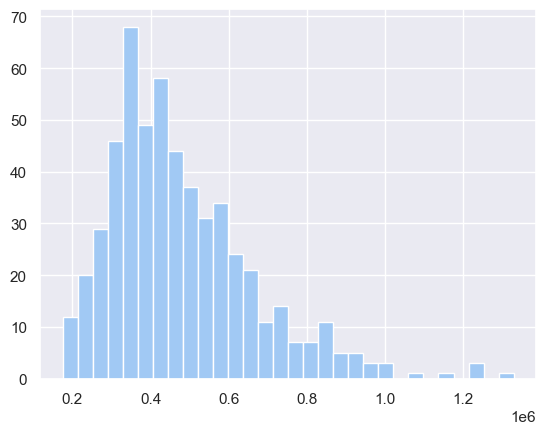

In [49]:
#Finding the skewness of target 
df_copy['Price ($)'].hist(bins=30)
plt.show()

From above, we can identify that there is a positive skewness where the mean is much higher than the median.

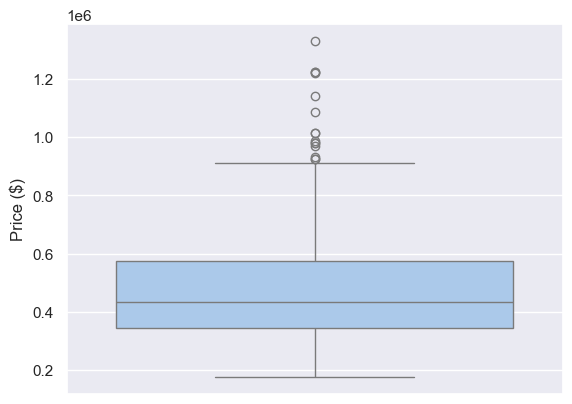

In [51]:
#Finding the outliers from our target
sns.boxplot(df['Price ($)'])
plt.show()

From above, we can see a number of outliers that are located towards the top. This further proves our point that there is a positive skenwss where the tail of the distribution extends further upwards (towards higher values).Most data points are concentrated near the lower end of the range, and fewer points are spread out towards the top.

In [53]:
# Assess skewness (symmetry) and kurtosis (tailedness):
from scipy.stats import skew, kurtosis

print("Skewness:", skew(df_copy['Price ($)']))
print("Kurtosis:", kurtosis(df_copy['Price ($)']))

Skewness: 1.2088998457878215
Kurtosis: 1.9312045083457292


In [54]:
# Calculate the IQR and bounds
Q1 = df_copy['Price ($)'].quantile(0.25)
Q3 = df_copy['Price ($)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_copy[(df_copy['Price ($)'] < lower_bound) | (df_copy['Price ($)'] > upper_bound)]

# Print outliers
print("Outliers:\n", outliers)


Outliers:
     House ID      City  House Area (sqm) No. of Bedrooms No. of Toilets  \
0          0   Chicago             742.0               4              2   
1          1    Denver             896.0               4              4   
2          2   Chicago             996.0               3              2   
3          3   Seattle             750.0               4              2   
4          4  New York             742.0               4              1   
5          5    Boston             750.0               3              3   
6          6    Denver             858.0               4              3   
7          7  New York            1620.0               5              3   
8          8    Denver             810.0               4              1   
9          9   Seattle             575.0               3              2   
10        10    Boston            1320.0               3              1   
11        11    Boston             600.0               4              3   
12        12  

Above data seems sensible since we can see that the rows that are present all have very high prices which is their similarity. Thus we will not remove them but consider capping them at the upper_bound (HAVE TO CAP OUTLIERS during the preprocessing of data)

####  <span style="background-color: lightblue;">1.21 Data Visualisation (features with target)</spam>

We will move on to visualising our data using multiple histograms, each histogram allows for the comparison of the distribution of varibales across different classes.

#### <span style="background-color: lightblue;"> We can used a heatmap to find correlations between the different properties </span>

In [59]:
categorical_cols = ["City", "Renovation Status" ,"No. of Bedrooms", "No. of Toilets", "Stories"]

numeric_cols = ["House Area (sqm)","House ID"]

numeric_cols_price = ["House Area (sqm)","House ID","Price ($)"]

catergorical_cols_price =["City","Renovation Status","Price ($)", "No. of Bedrooms", "No. of Toilets", "Stories"]

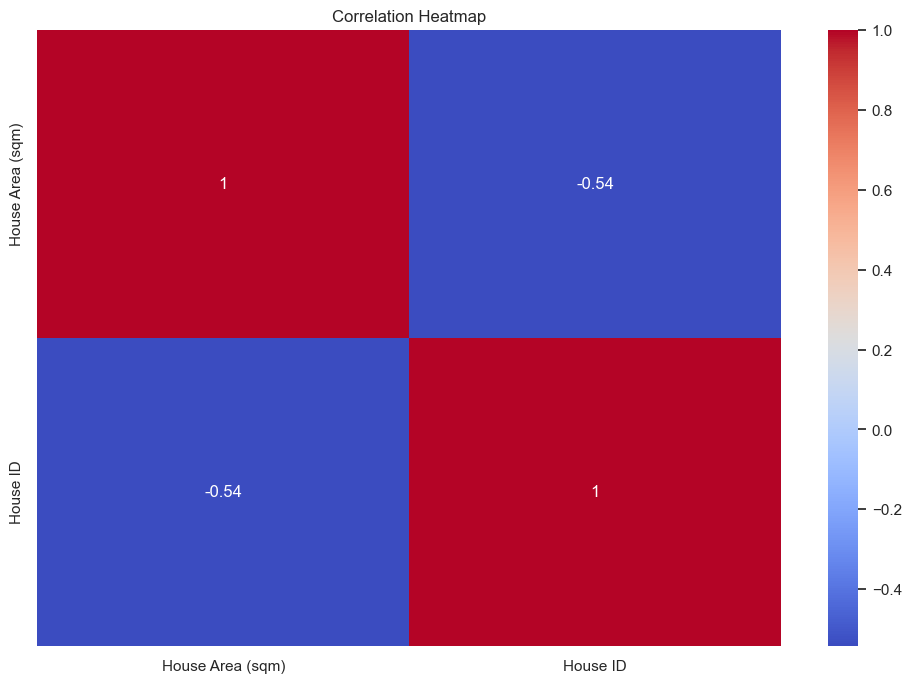

In [60]:
# Calculate the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In summary, the heatmap shows that there is a moderate negative correlation (-0.54) between "House ID" and "House Area (sqm)". This means that, in this dataset, houses with higher IDs tend to have smaller areas in square meters.

#### <span style="background-color: lightblue;"> We can use histograms/box plots/density plots to understand the distributions between numerical features</span>

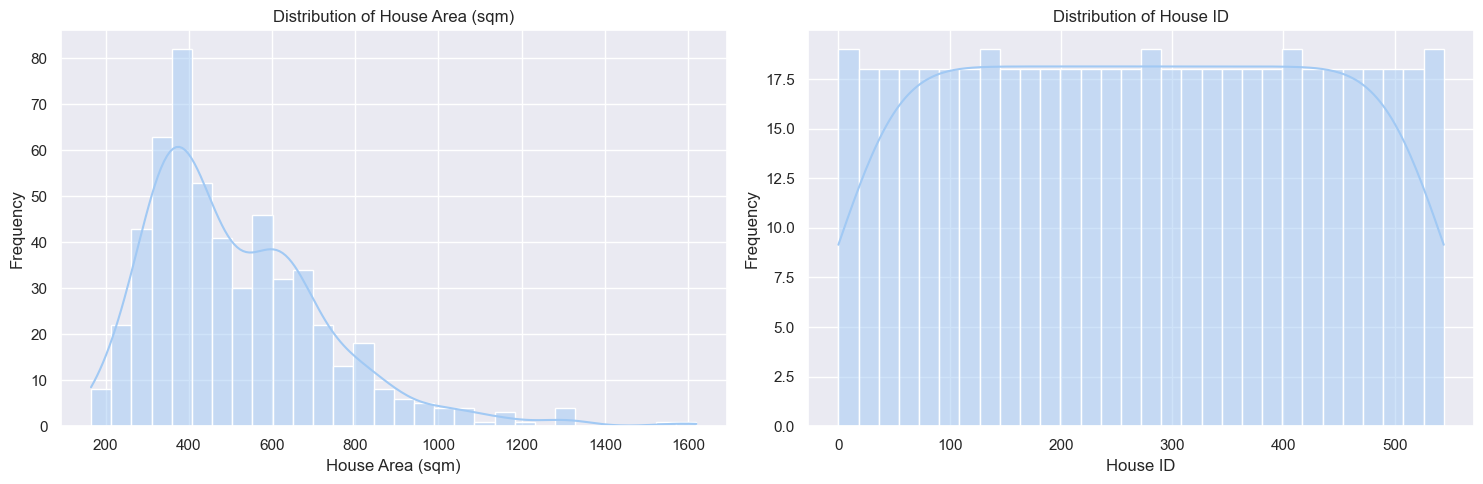

In [63]:
# Create subplots
n_rows = 1
n_cols =2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Plot histograms for numerical features
for i, col in enumerate(numeric_cols):
    sns.histplot(df_copy[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

From above, we can definitely see that the 'House Area (sqm)' is skewed positively or towards the right

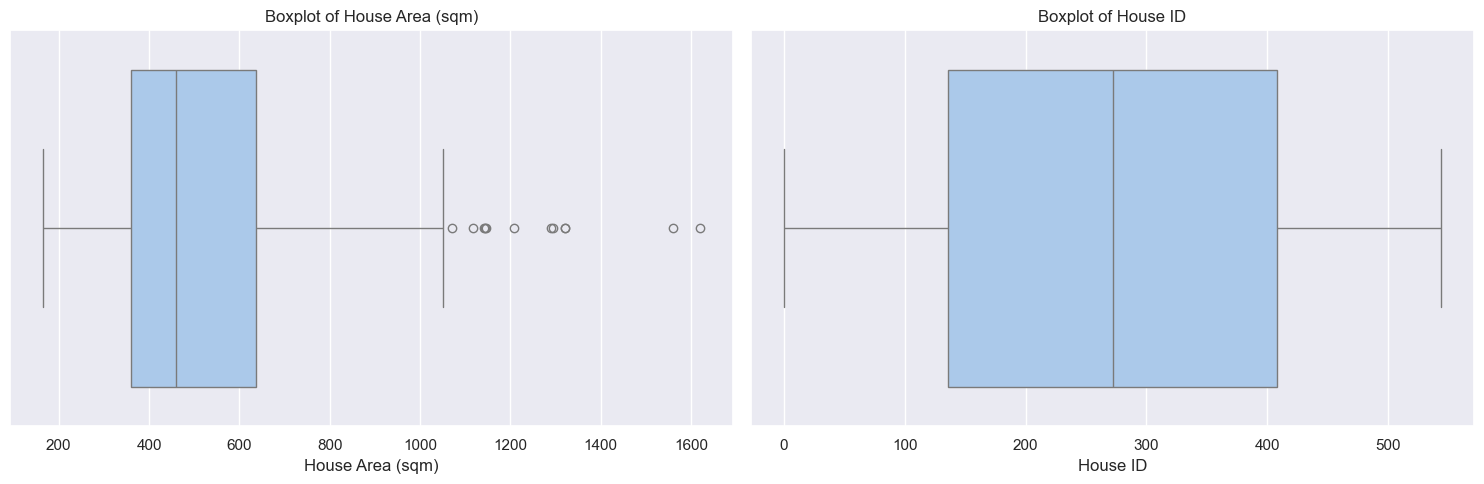

In [65]:
n_rows = 1
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Plot boxplots for numerical features
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_copy, x=col, ax=axes[i])  # Specify the subplot axis
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)

# Hide the extra plots if there are fewer than n_rows * n_cols categories
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

We can see that there are some outliers located on the right side of our 'House Area (sqm)' which actually further proves the point of it being skewed to the right

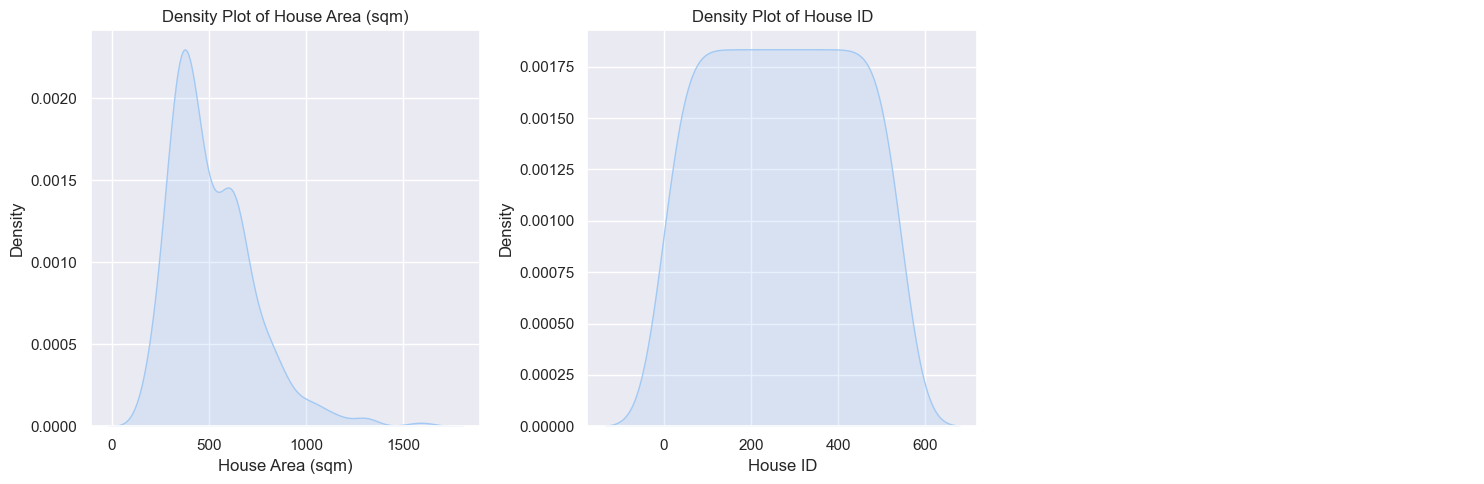

In [67]:
# Density plots with corrected argument
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Plot density plots for numerical features
for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=df_copy, x=col, fill=True, ax=axes[i])  # Pass ax to place the plot
    axes[i].set_title(f'Density Plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide the extra plots if there are fewer than n_rows * n_cols categories
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Similar to the graphs above, we do see a skewness in House Area (sqm)

#### Next let us try to visualise the categorical variables

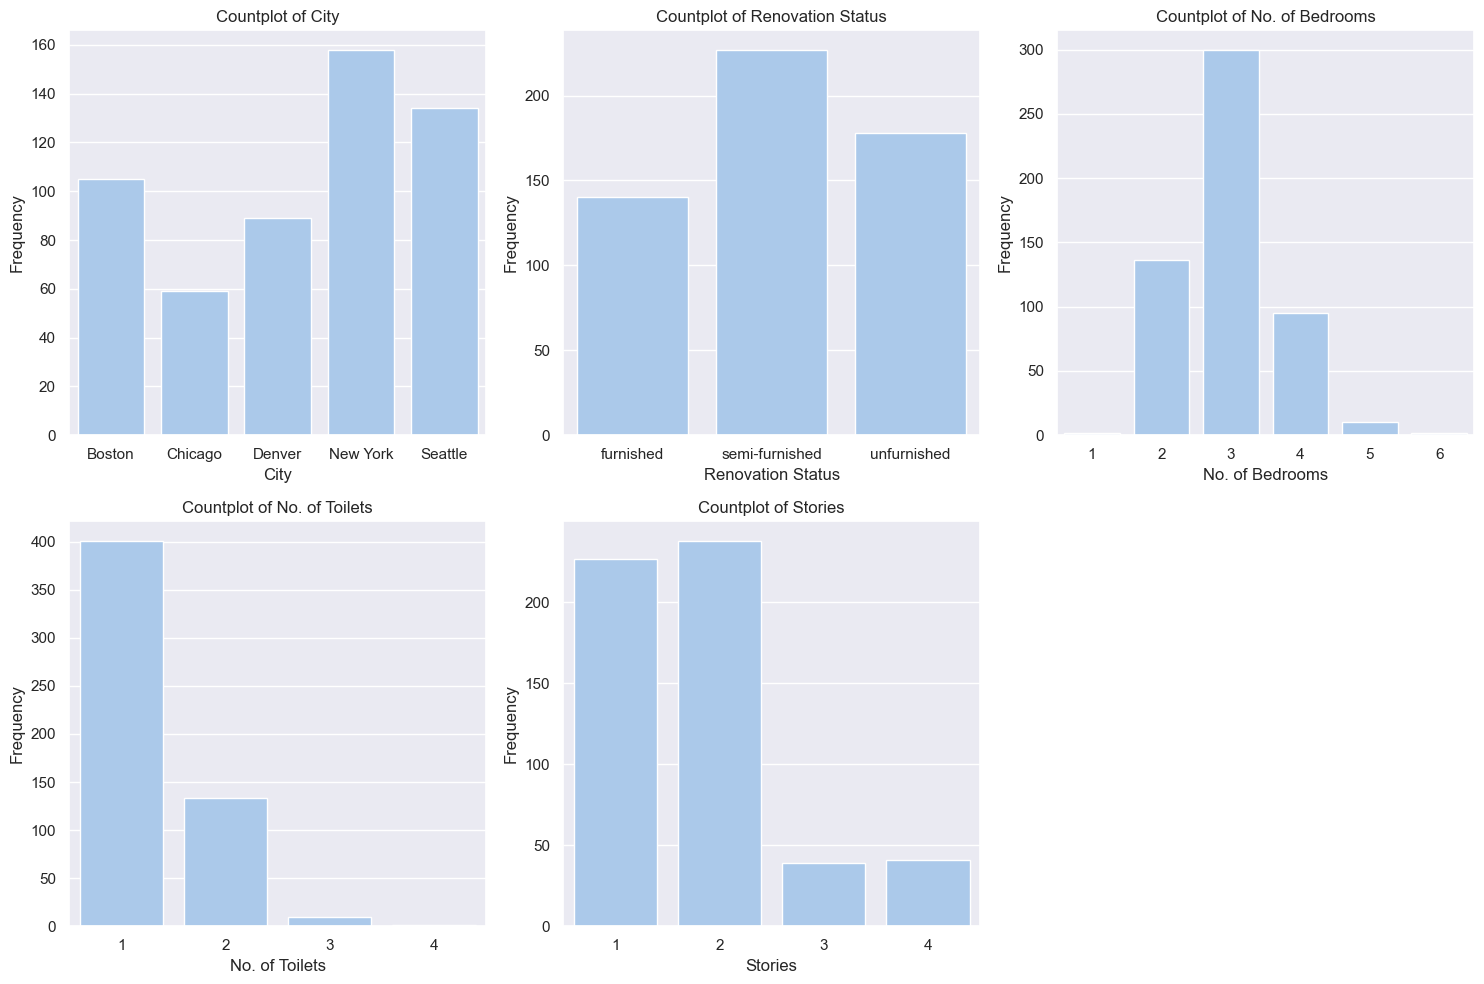

In [70]:
# Countplots for categorical columns
n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Loop through categorical columns and create countplots
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df_copy, x=col, ax=axes[i])  # Specify 'x' for categorical column
    axes[i].set_title(f'Countplot of {col}')
    axes[i].set_ylabel('Frequency')

# Hide the extra plot if there are fewer than 6 categories
for j in range(len(categorical_cols), len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

# Adjust layout and show all plots
plt.tight_layout()
plt.show()

From above, we can see the frequency/count of which classes in each of the categories, which classes have more and which classes have less. What is interesting to me is that there are some classes that does not have any frequency.No frequency may raise biasness as we encode later on

#### Let us now find relationships between features and target

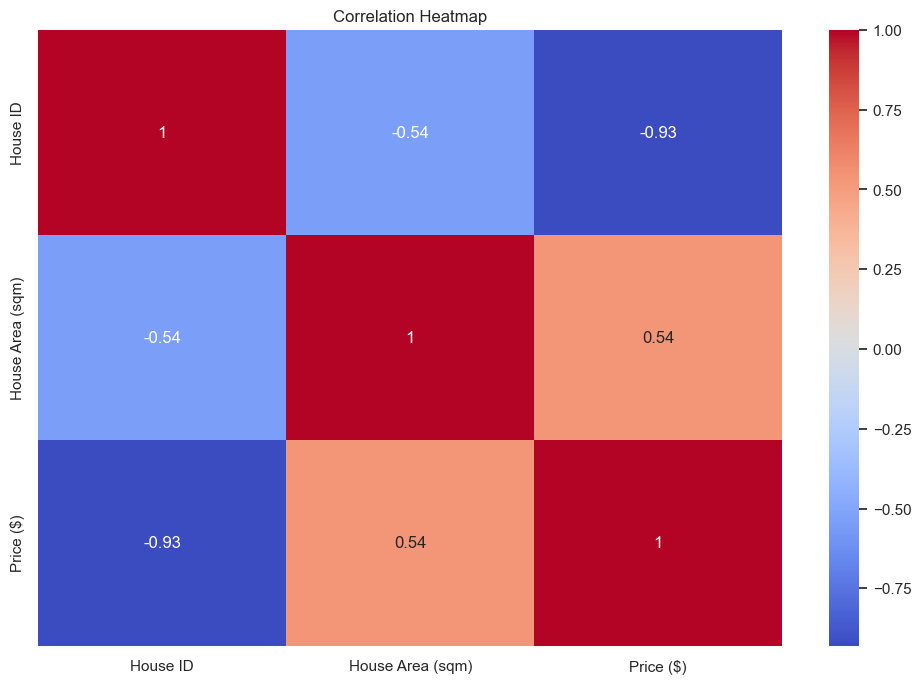

In [73]:
# Automatically select numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64','int32']).columns

# Calculate the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

1) House ID and House Area (sqm):

* The correlation coefficient between "House ID" and "House Area (sqm)" is -0.54. This indicates a moderate negative correlation, meaning that as the House ID increases, the House Area tends to decrease, and vice versa.
2) House ID and Price ($):

* The correlation coefficient between "House ID" and "Price" is -0.93. This indicates a strong negative correlation, suggesting that higher House IDs are associated with lower prices. This could imply that the houses with higher IDs are generally less expensive.
3) House Area (sqm) and Price :

* The correlation coefficient between "House Area (sqm)" and "Price ($)" is 0.54. This indicates a moderate positive correlation, meaning that larger houses tend to have higher prices. This is a typical real estate trend where the size of the house is directly proportional to its price.

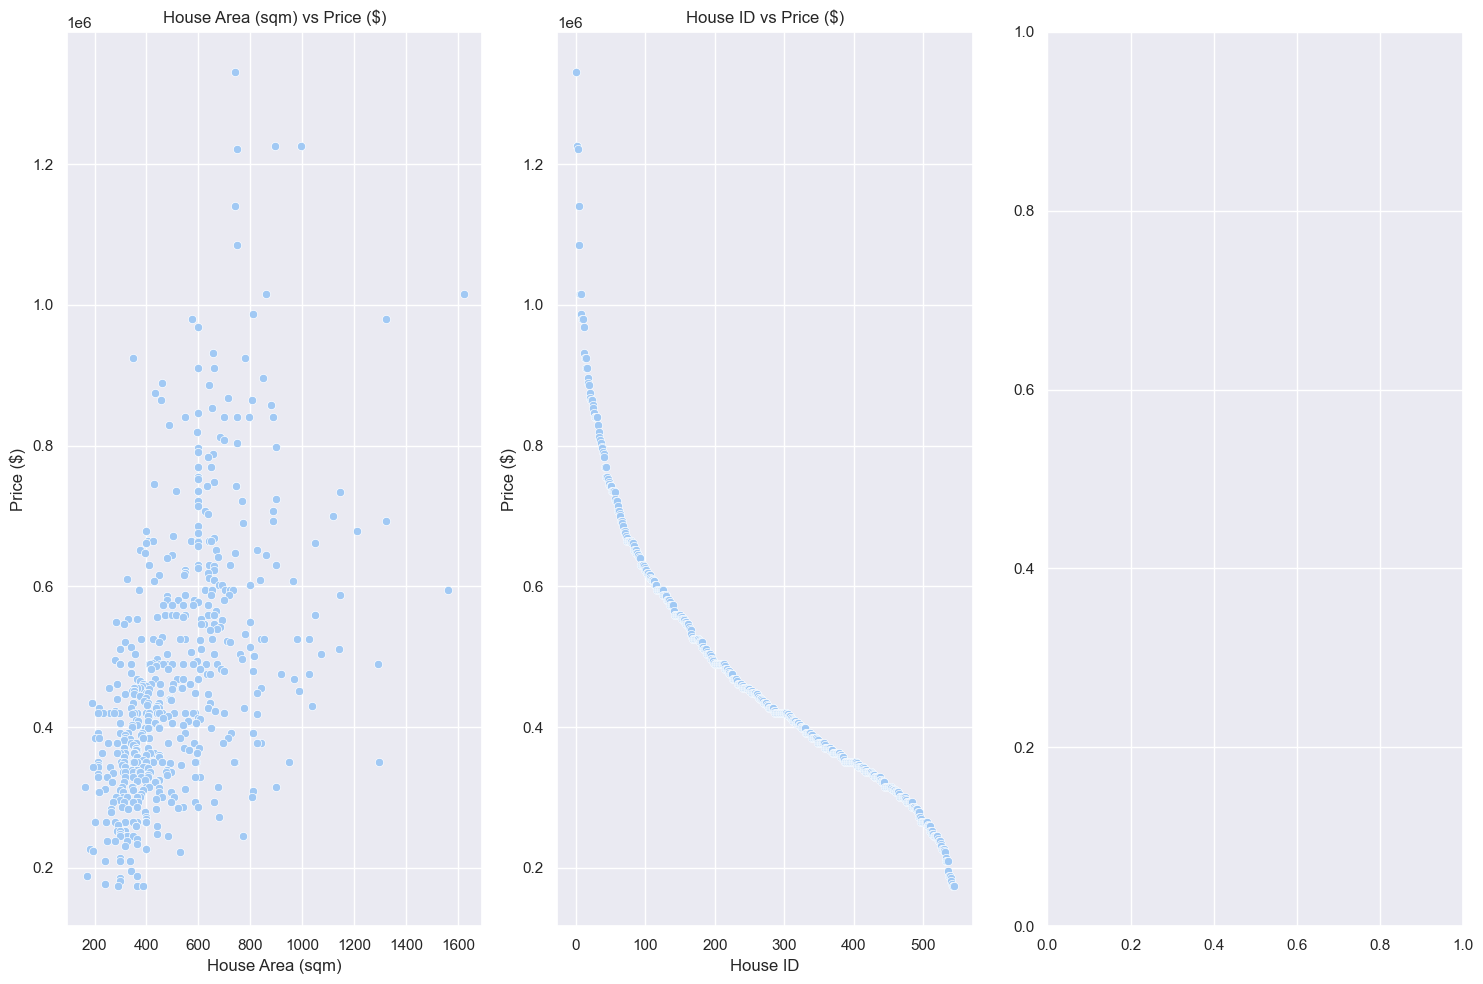

In [75]:
# Scatter plots for numerical features against Price
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

numeric_cols_price = ["House Area (sqm)", "House ID"]
for i, col in enumerate(numeric_cols_price):
    sns.scatterplot(data=df_copy, x=col, y='Price ($)', ax=axes[i])
    axes[i].set_title(f'{col} vs Price ($)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price ($)')
    
# Hide the extra plot if there are fewer than 6 categories
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')  # Hide the extra subplots   
plt.tight_layout()
plt.show()


1) House Area (sqm) vs Price ($):

* There is a general positive trend with some variation. Larger houses tend to have higher prices, but there's significant scatter, indicating that house area isn't the sole predictor of price.

#### Categorical variables against target

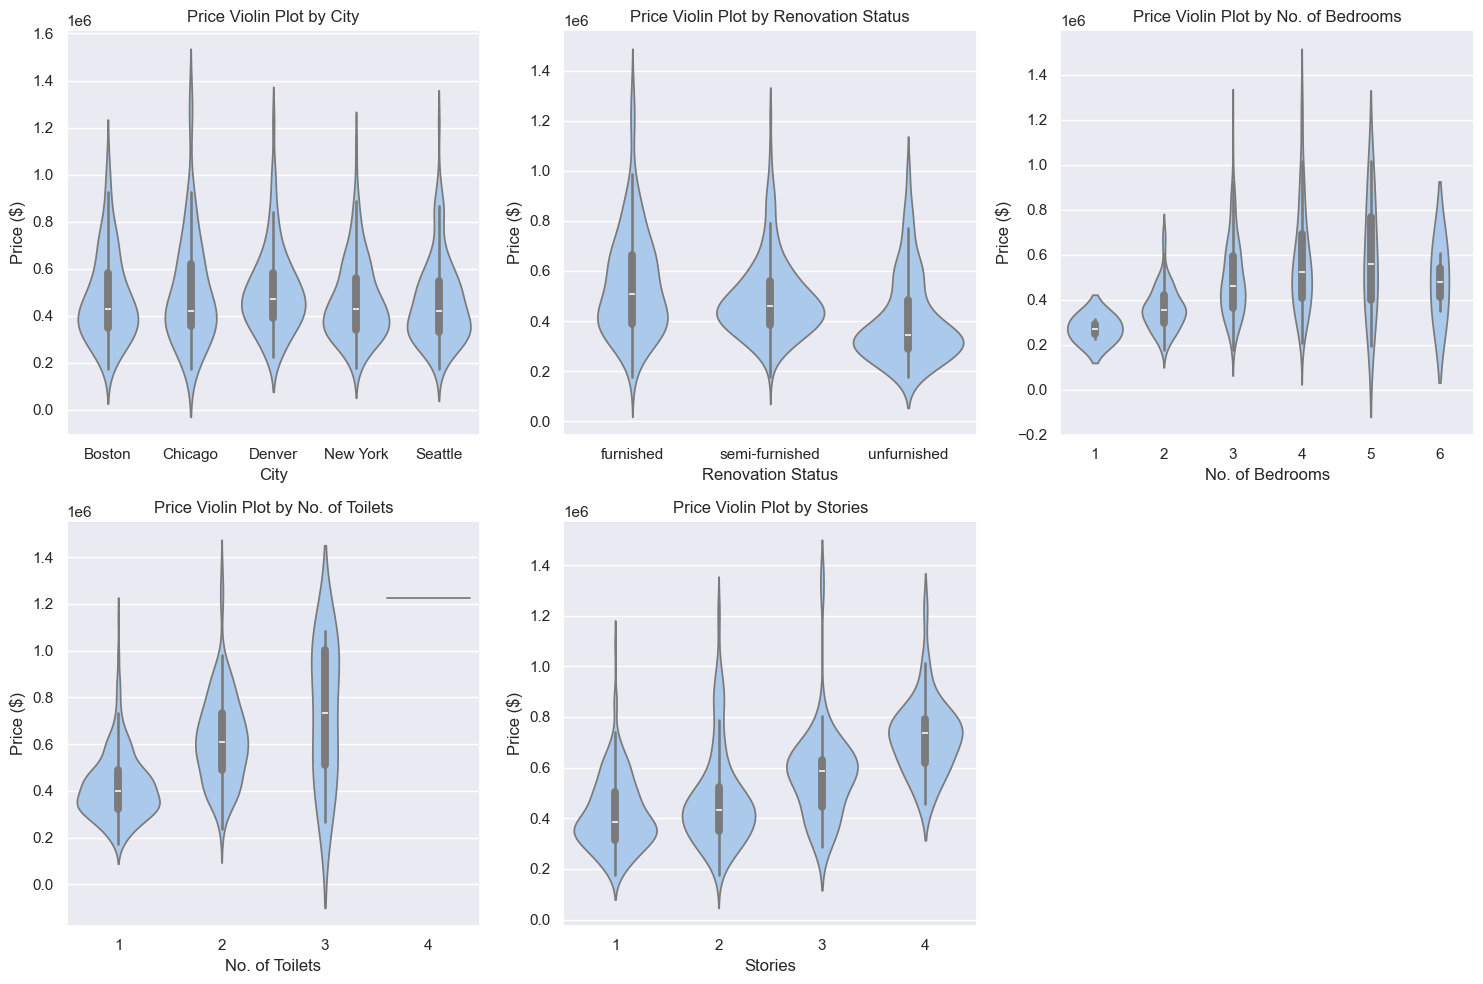

In [78]:
# Violin plots for Price against categorical features
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.violinplot(data=df_copy, x=col, y='Price ($)', ax=axes[i])
    axes[i].set_title(f'Price Violin Plot by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price ($)')

# Hide the extra plot if there are fewer than 6 categories
for j in range(len(categorical_cols), len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

plt.tight_layout()
plt.show()


* Wider violin = larger variability of that class
* Violin that is fatter on the right = right skewness
* Longer violin = wide range of values where tails of the violin represents data points at the extremes(min and max)
* As for the head, a longer or wider head means many data points are concentrated around that range which also reflects the high density of the values near the mode

1) Price Violin Plot by City:

* The distribution of prices across different cities shows that most cities have a similar range of house prices, with no city standing out significantly in terms of price distribution.
* The median price (white dot) is relatively similar across cities, indicating that house prices do not vary drastically by city.
2) Price Violin Plot by Renovation Status:

* ouses that are fully furnished tend to have higher prices compared to semi-furnished and unfurnished houses.
* There is a noticeable difference in the distribution, with unfurnished houses generally having lower prices.
3) Price Violin Plot by Number of Bedrooms:

* Houses with more bedrooms tend to have a higher price, particularly noticeable in houses with 5 and 6 bedrooms.
* The spread of prices also increases with the number of bedrooms, indicating that houses with more bedrooms have a wider range of prices.
4) Price Violin Plot by Number of Toilets:

*Houses with more toilets tend to have higher prices, especially noticeable in houses with 3 and 4 toilets.
* The price distribution becomes wider as the number of toilets increases, similar to the trend seen with the number of bedrooms.
5) Price Violin Plot by Stories:

* Houses with more stories generally have higher prices, with 3-story and 4-story houses showing a higher median price.
* The distribution of prices for houses with different numbers of stories indicates that houses with more stories not only have h* igher prices but also a greater range of prices.

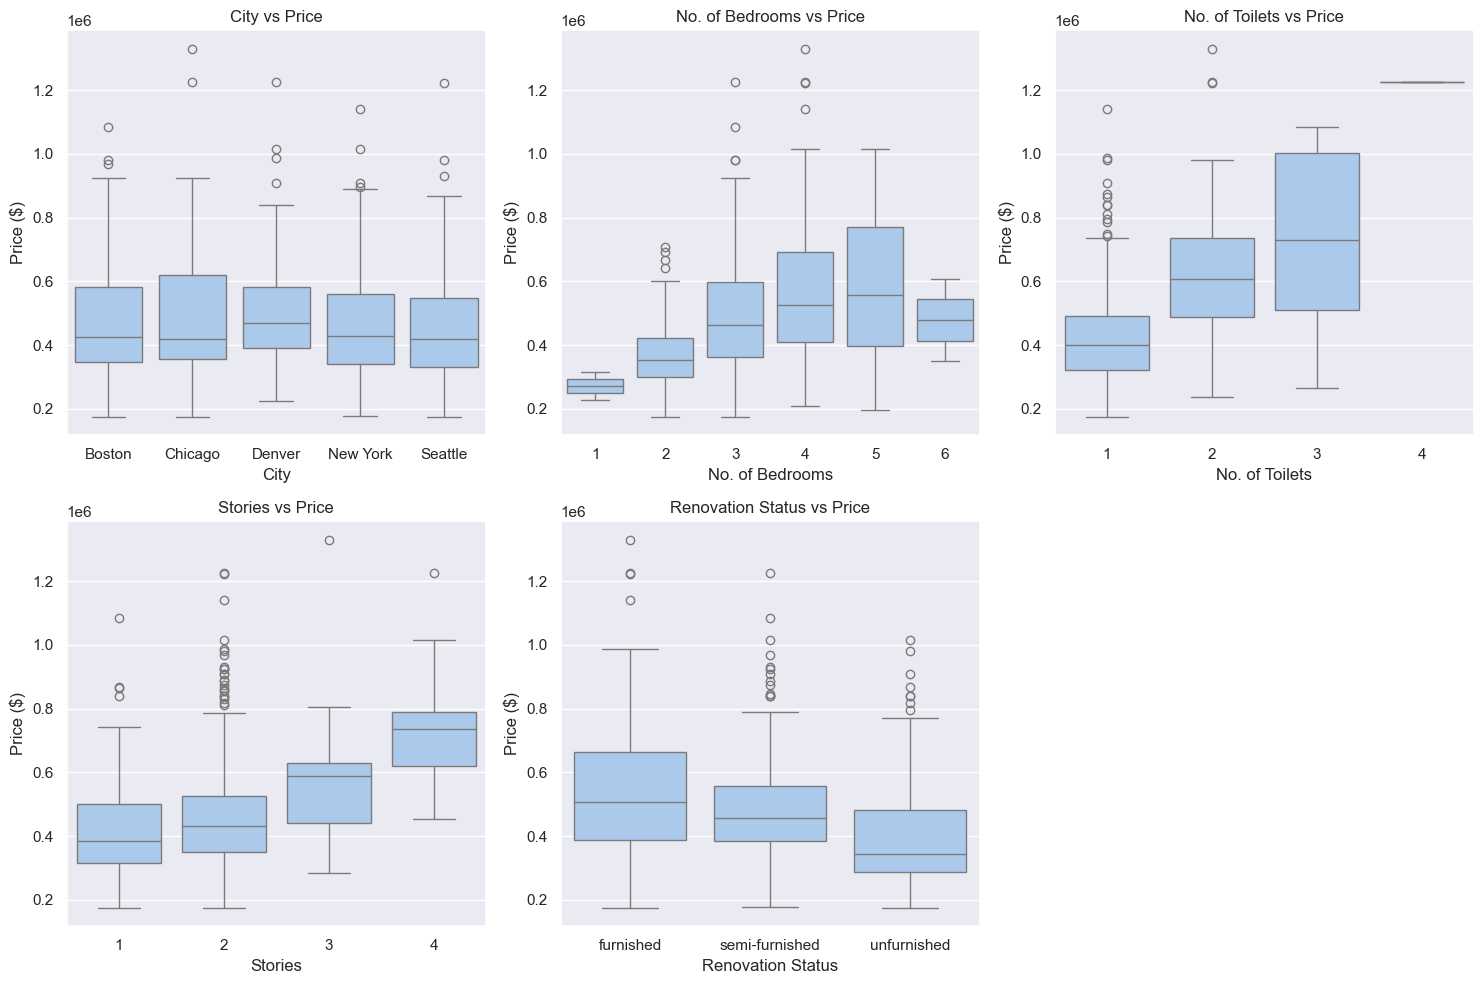

In [81]:
# List of categorical columns
categorical_cols = ["City", "No. of Bedrooms", "No. of Toilets", "Stories", "Renovation Status"]

# Create 2 rows, 3 columns of subplots (5 plots in total, the last subplot will be empty)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop over categorical columns and plot
for i, col in enumerate(categorical_cols):
    sns.boxplot(data=df, x=col, y="Price ($)", ax=axes[i])
    axes[i].set_title(f"{col} vs Price")
    
# Remove the unused subplot (the last one)
axes[-1].axis('off')

plt.tight_layout()
plt.show()

The boxplot provided shows an unusual ordering of the number of bedrooms: 1, 2, 3, 6, 4, 5. This ordering suggests that the data might not be sorted correctly by the number of bedrooms, which could be an issue with how the categorical data for "No. of Bedrooms" was handled or encoded.


## Step 2. Data preparation

In [84]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lars, Lasso, LassoLars, BayesianRidge, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_validate
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

#### 2.1 (Handling the skewness of our target)

To reduce skewness in the target variable (e.g., Price), a logarithmic transformation is often used. This transformation compresses large values more than smaller ones, making the distribution closer to normal, which many machine learning models prefer for better performance.

In [87]:
import numpy as np
import pandas as pd

# Drop unnecessary columns
df = df_copy.drop("House ID", axis=1)

# Log transformation to reduce skewness
scaled_df = df.copy()
scaled_df["House Area (sqm)"] = np.log1p(scaled_df["House Area (sqm)"])
scaled_df["Price ($)"] = np.log1p(scaled_df["Price ($)"])

# Display summary and skewness for transformed columns
print("Skewness Before:\n", df[["House Area (sqm)", "Price ($)"]].skew())
print("Skewness After:\n", scaled_df[["House Area (sqm)", "Price ($)"]].skew())


Skewness Before:
 House Area (sqm)    1.321188
Price ($)           1.212239
dtype: float64
Skewness After:
 House Area (sqm)    0.135786
Price ($)           0.140865
dtype: float64


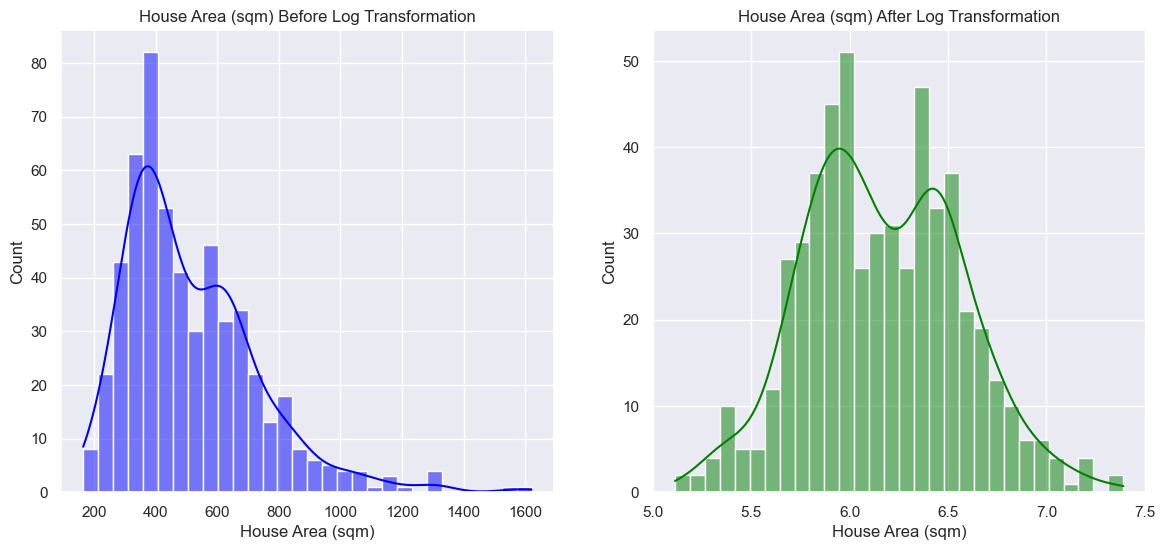

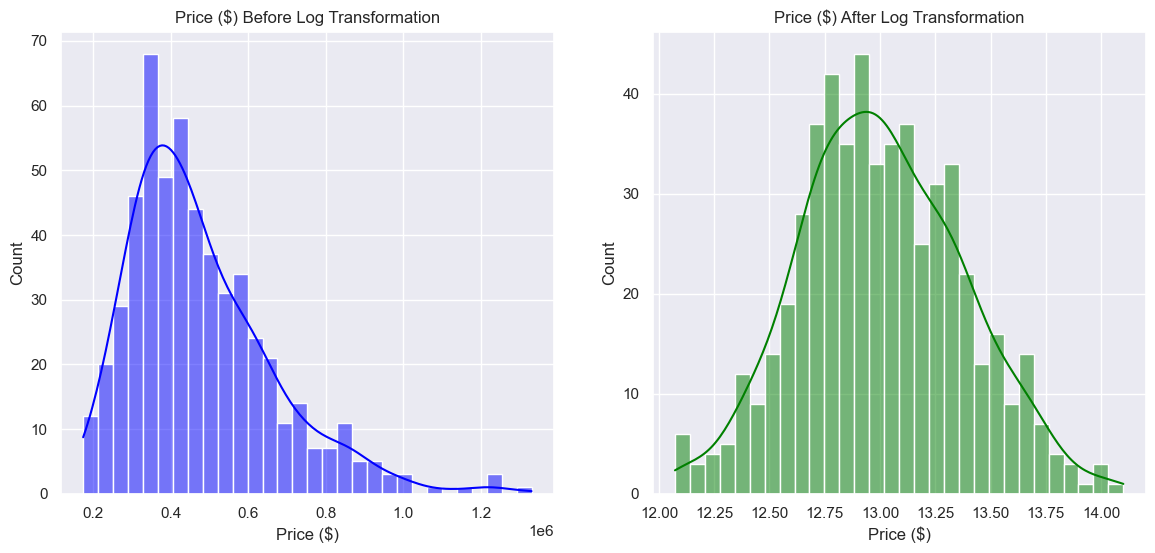

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms
for col in ["House Area (sqm)", "Price ($)"]:
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"{col} Before Log Transformation")
    plt.subplot(1, 2, 2)
    sns.histplot(scaled_df[col], kde=True, bins=30, color="green")
    plt.title(f"{col} After Log Transformation")
    plt.show()


As you can see above, the skewness decreased in value and came closer to 0, showing the success of log

#### 2.2 (Conversion of categorical features to numerical features) mix with scaling

We have to encode because categorical data cannot be typically handled by machine learning algorithms because most algorithms are primarily designed to operate with numerical data only. Thus, we have to encode them as numerical values

There are 2 ways we can encode this feature 

* One-Hot Encoding: For categories without ordinal relationships, this creates binary columns 
* Ordinal Encoding: If "Quality" has an inherent order  you can assign numeric values to each category.

Theere are 2 ways we can standardize our data :<br>
* Standard Scalar
* Robust Scalar

Standard Scalar:<br>
It standardizes the features by transforming them into a distribution with Mean = 0, Standard Deviation = 1. It works well when the data is normally distributed or when features have a Gaussian-like distribution. Linnear models such as logistic regression will perform better when features are noramlly dustributed

Robust Scalar:<br>
It standardizes the features using the mdeian and interquartile range. Only use this if your data contains significant outliers since it uses the median and IQE which will influence less for extreme values

In [97]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Convert to string for ordinal encoding
X = scaled_df.drop("Price ($)", axis=1)
y = scaled_df["Price ($)"]

X["No. of Bedrooms"] = X["No. of Bedrooms"].astype(str)
X["No. of Toilets"] = X["No. of Toilets"].astype(str)
X["Stories"] = X["Stories"].astype(str)

# Define ordinal categories
ordinal_encode = [
    ["unfurnished", "semi-furnished", "furnished"], 
    ["1", "2", "3", "6", "4", "5"], 
    ["1", "2", "3", "4"], 
    ["1", "2", "3", "4"]
]

# Column Transformer for encoding
ct = ColumnTransformer(
    transformers=[
        ("standard_scaler", StandardScaler(), ["House Area (sqm)"]),
        ("one_hot_encoder", OneHotEncoder(), ["City"]),
        ("ordinal_toilet_no_and_stories_encoder", 
         OrdinalEncoder(categories=ordinal_encode), 
         ["Renovation Status", "No. of Bedrooms", "No. of Toilets", "Stories"])
    ],
    remainder="passthrough"
)

# Fit and transform data
X_transformed = ct.fit_transform(X)

# Convert back to DataFrame
# Extract feature names from the transformers
feature_names = (
    ct.named_transformers_["one_hot_encoder"].get_feature_names_out(["City"]).tolist()
    + ["House Area (scaled)"]
    + ["Renovation Status", "No. of Bedrooms", "No. of Toilets", "Stories"]
    + [col for col in X.columns if col not in ["City", "House Area (sqm)", "Renovation Status", 
                                               "No. of Bedrooms", "No. of Toilets", "Stories"]]
)

# Create DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Ensure the index matches the original data
X_transformed_df.index = X.index

# Display the transformed DataFrame
print("Transformed DataFrame:\n", X_transformed_df.head())


Transformed DataFrame:
    City_Boston  City_Chicago  City_Denver  City_New York  City_Seattle  \
0     1.119455           0.0          1.0            0.0           0.0   
1     1.593861           0.0          0.0            1.0           0.0   
2     1.860065           0.0          1.0            0.0           0.0   
3     1.146429           0.0          0.0            0.0           0.0   
4     1.119455           0.0          0.0            0.0           1.0   

   House Area (scaled)  Renovation Status  No. of Bedrooms  No. of Toilets  \
0                  0.0                2.0              4.0             1.0   
1                  0.0                2.0              4.0             3.0   
2                  0.0                1.0              2.0             1.0   
3                  1.0                2.0              4.0             1.0   
4                  0.0                2.0              4.0             0.0   

   Stories  
0      2.0  
1      3.0  
2      1.0  
3      1.0

In [98]:
# Function to compute IQR
def compute_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    return IQR

# Compare IQRs before and after log transformation
for col in ["House Area (sqm)", "Price ($)"]:
    iqr_before = compute_iqr(df[col])
    iqr_after = compute_iqr(scaled_df[col])
    print(f"IQR for {col}: Before = {iqr_before}, After = {iqr_after}")


IQR for House Area (sqm): Before = 276.0, After = 0.5678916972392827
IQR for Price ($): Before = 231000.0, After = 0.5148977758647426


#### 2.3 (Splitting data)

In [100]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed_df, y, test_size=0.2, random_state=54
)

# Verify split sizes
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (436, 10)
Testing Data Shape: (109, 10)


## Step 3 (Model Selection)

In [102]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


I had to ensure that my X_train and X_test were of the correct type because previously i used CT and it converted to numpy array but i converted it back to dataframe too. This is a double check

In [104]:
print(type(X_train))  # Should be <class 'pandas.core.frame.DataFrame'>
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from math import sqrt

In [106]:
# List of models
models = [
    ("DummyRegressor", DummyRegressor()),
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso(random_state=23)),
    ("BayesianRidge", BayesianRidge()),
    ("SGDRegressor", SGDRegressor(random_state=23)),
    ("SVR", SVR()),
    ("KernelRidge", KernelRidge()),
    ("KNeighborsRegressor", KNeighborsRegressor()),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=23)),
    ("GradientBoostingRegressor", GradientBoostingRegressor(random_state=23)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=23)),
]

In [107]:
# Initialize empty list to store results
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
results = []

# Loop over each model
for name, model in models:
    # Create a pipeline (if necessary, can be adjusted based on needs)
    pipeline = make_pipeline(model)  # Since no ColumnTransformer, just pass the model
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    
    # Calculate RMSE using the new method
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Append results
    results.append({
        'Model': name,
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae
    })

# Convert results into a DataFrame for better readability
import pandas as pd
results_df = pd.DataFrame(results)

# Sort by R-squared and RMSE (lower RMSE is better)
sorted_results = results_df.sort_values(by=["R-squared", "RMSE"], ascending=[False, True])

In [108]:
# Sort by R-squared and RMSE (lower RMSE is better)
sorted_results = results_df.sort_values(by=["R-squared", "RMSE"], ascending=[False, True])


In [109]:
print(sorted_results)

                        Model  R-squared      RMSE       MAE
4               BayesianRidge   0.622898  0.217734  0.176805
2                       Ridge   0.621047  0.218267  0.177422
1            LinearRegression   0.620626  0.218389  0.177538
6                         SVR   0.582771  0.229025  0.180381
10  GradientBoostingRegressor   0.581980  0.229242  0.180740
8         KNeighborsRegressor   0.534664  0.241869  0.191287
5                SGDRegressor   0.510407  0.248093  0.206997
11      RandomForestRegressor   0.471085  0.257863  0.197358
9       DecisionTreeRegressor   0.118479  0.332899  0.254927
0              DummyRegressor  -0.000016  0.354568  0.283276
3                       Lasso  -0.000016  0.354568  0.283276
7                 KernelRidge  -0.515901  0.436548  0.361895


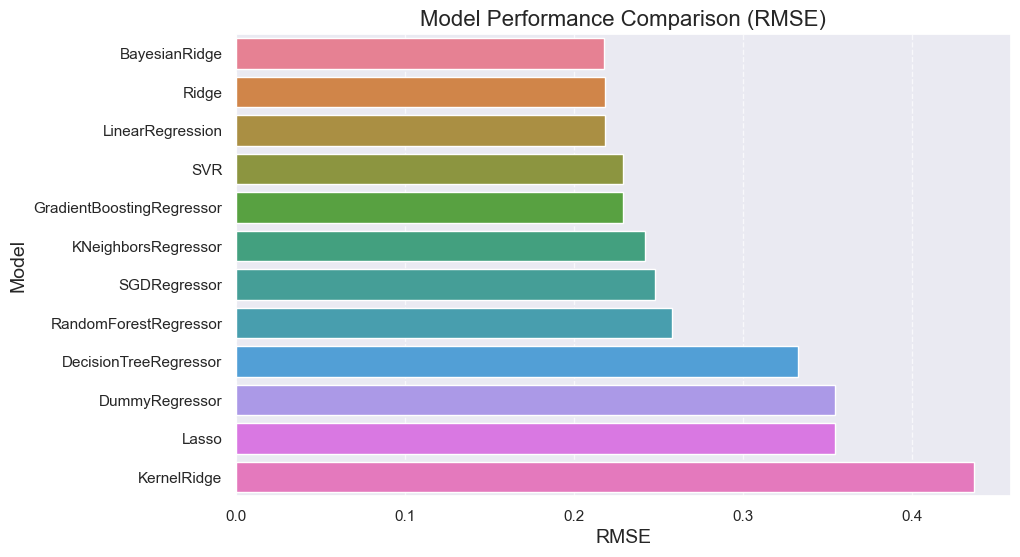

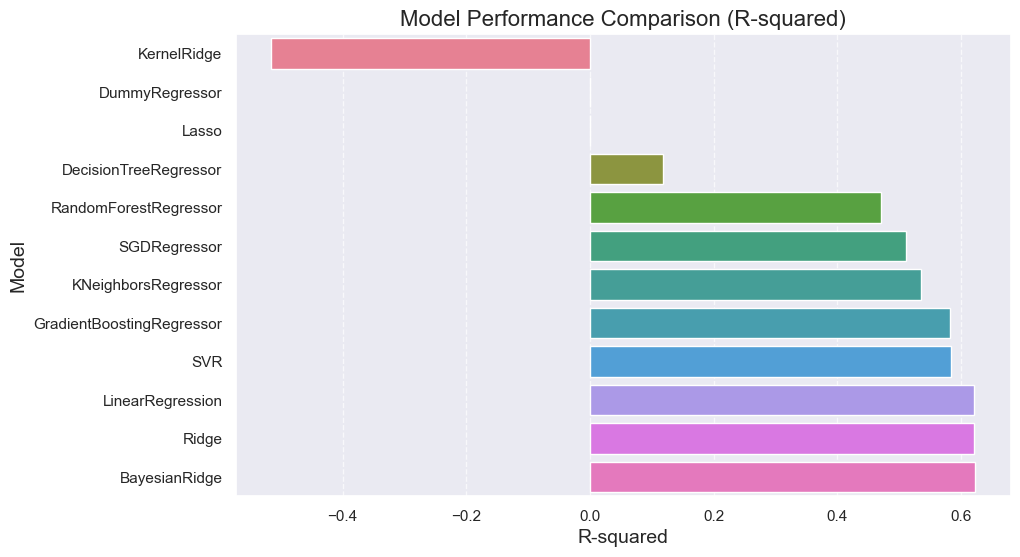

In [110]:
def plot_model_performance(results_df, metric="RMSE"):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=results_df.sort_values(by=metric), 
        x=metric, 
        y="Model", 
        hue="Model",  # Assign `Model` to hue
        dodge=False,  # Ensure bars are not split
        legend=False  # Remove redundant legend
    )
    plt.title(f"Model Performance Comparison ({metric})", fontsize=16)
    plt.xlabel(metric, fontsize=14)
    plt.ylabel("Model", fontsize=14)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

# Example: Plot RMSE and R²
plot_model_performance(sorted_results, metric="RMSE")
plot_model_performance(sorted_results, metric="R-squared")

From above we can see how well the dummy model performed based on the different metrics used that will help in identifying the efficiency of our models

1)  Root Mean Squared Error (RMSE)<br>
* It is made up of the square root of the average differences between the actual and predicted values
*  RMSE indicates the magnitude of error in predictions, with a focus on larger errors because squaring amplifies their impact.
* A lower RMSE is better, as it means the predictions are closer to actual values.

2) Mean Absolute Error (MAE)<br>
* It is the average of the absolute difference between the actual and the predicted values
* MAE provides a straightforward measure of prediction error magnitude without exaggerating large errors.
* A lower MAE is better.

3) R^2 score (Coefficient of determination)<br>
* It is the proportion of the variance in the target variable that the model can explain
* Higher R^2 values indicate that the model explains more variance in the taregt variable
* Lower R^2 values suggests poor model fit

The Bayesian Ridge, Ridge, and Linear Regression models are performing best based on the provided metrics. These models have high R² values and low RMSE/MAE, making them suitable choices for task. On the other hand, models like DecisionTreeRegressor, DummyRegressor, and Lasso should be avoided, as they are underperforming.

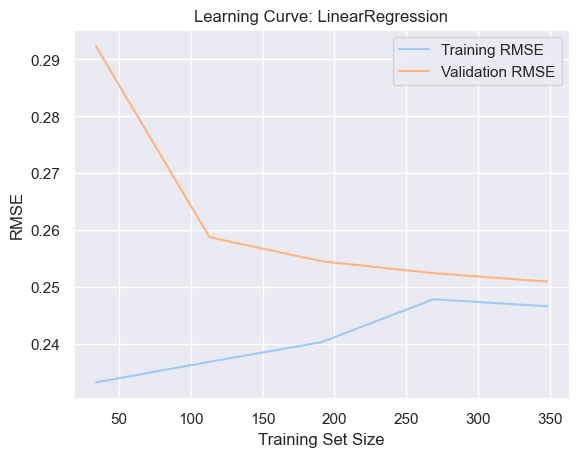

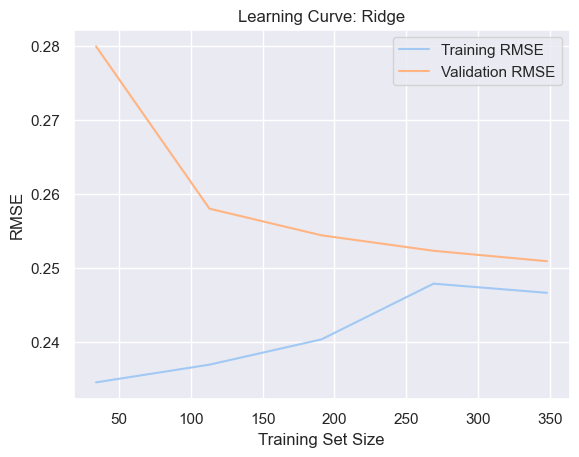

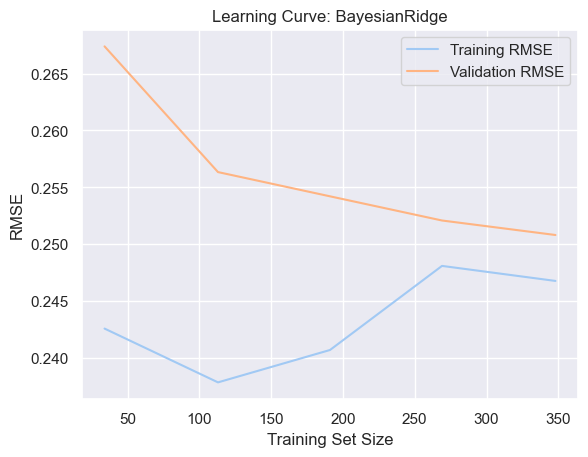

In [116]:
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_rmse = np.sqrt(-train_scores)
    test_rmse = np.sqrt(-test_scores)

    plt.figure()
    plt.plot(train_sizes, train_rmse.mean(axis=1), label="Training RMSE")
    plt.plot(train_sizes, test_rmse.mean(axis=1), label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

# Plot learning curve for top models
for name, model in models:
    if name in sorted_results.head(3)["Model"].values:
        plot_learning_curve(model, X_train, y_train, title=f"Learning Curve: {name}")


In [117]:
model = Ridge()
model.fit(X_train, y_train)

# Extract coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.coef_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

               Feature  Importance
8       No. of Toilets    0.192189
0          City_Boston    0.176696
9              Stories    0.110448
6    Renovation Status    0.100488
7      No. of Bedrooms    0.017831
1         City_Chicago    0.015688
2          City_Denver    0.002003
4         City_Seattle   -0.001475
3        City_New York   -0.005770
5  House Area (scaled)   -0.010445


Above shows which features the model considers most important with the higher the value meaning the higher its significance

### Hypertuning our best performing model (Beyesian ridge)

We can all conclude that Bayesian Ridge,ridge and linear regression did perform the best out of all models due to the results it produced based on the metrics used. 

#### Let us start off by understanding the parameters to tune

Bayesian Ridge
*  <mark>alpha_1, alpha_2</mark>: Hyperparameters controlling the shape of the prior on weights.
  
* <mark>lambda_1, lambda_2</mark>: Hyperparameters controlling the precision of the noise.
  
* <mark>n_iter</mark>: Maximum of iterations.

In [123]:
#  hyperparameters for Bayesian Ridge model
param_grid = {
    'alpha_1': [1e-6, 1e-3, 1e-1, 1],
    'alpha_2': [1e-6, 1e-3, 1e-1, 1],
    'lambda_1': [1e-6, 1e-3, 1e-1, 1],
    'lambda_2': [1e-6, 1e-3, 1e-1, 1],
    'max_iter': [300, 500, 1000],  # Use max_iter instead of n_iter
    'tol': [1e-4, 1e-3, 1e-2]
}


In [124]:
# Initialize the Bayesian Ridge model
bayesian_ridge = BayesianRidge()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=bayesian_ridge, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(cv=5, estimator=BayesianRidge(), n_jobs=-1,
             param_grid={'alpha_1': [1e-06, 0.001, 0.1, 1],
                         'alpha_2': [1e-06, 0.001, 0.1, 1],
                         'lambda_1': [1e-06, 0.001, 0.1, 1],
                         'lambda_2': [1e-06, 0.001, 0.1, 1],
                         'max_iter': [300, 500, 1000],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='neg_mean_squared_error', verbose=1)

In [125]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_


Best Hyperparameters: {'alpha_1': 1e-06, 'alpha_2': 1, 'lambda_1': 1, 'lambda_2': 0.001, 'max_iter': 300, 'tol': 0.0001}


In [126]:
# Predict using the best model
y_pred = best_model.predict(X_test)

# Calculate R-squared, RMSE, and MAE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the performance metrics
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


R-squared: 0.6234563648183346
RMSE: 0.21757246142970152
MAE: 0.17657445770373734


In [127]:
# First, evaluate the untuned model
untuned_model = BayesianRidge()
untuned_model.fit(X_train, y_train)
y_pred_untuned = untuned_model.predict(X_test)

# Calculate R-squared, RMSE, and MAE for untuned model
r2_untuned = r2_score(y_test, y_pred_untuned)
rmse_untuned = np.sqrt(mean_squared_error(y_test, y_pred_untuned))
mae_untuned = mean_absolute_error(y_test, y_pred_untuned)

# Print the performance of the untuned model
print("Untuned Model:")
print(f"R-squared: {r2_untuned}")
print(f"RMSE: {rmse_untuned}")
print(f"MAE: {mae_untuned}")

# Print comparison of the tuned model
print("\nTuned Model:")
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


Untuned Model:
R-squared: 0.6228982244152632
RMSE: 0.2177336525945281
MAE: 0.17680514306933343

Tuned Model:
R-squared: 0.6234563648183346
RMSE: 0.21757246142970152
MAE: 0.17657445770373734


From the above, we can gather some conclusions:
* The R-squared value for the tuned model is slightly higher than the untuned model, indicating that the tuned model explains a marginally better proportion of the variance in the target variable. The improvement is quite small, but it is positive.
* The RMSE has improved slightly in the tuned model, but the difference is very small (about 0.0001). This suggests that the tuned model has a marginally better fit, as RMSE measures the average magnitude of errors
* The MAE is similarly improved by a very small amount (0.0002). This also indicates that the tuned model is marginally better in terms of the absolute difference between the predicted and actual values.

#### Hypertuning our second best model (ridge)

Before we get started, let us understand the parameters in Ridge
1) alpha:
* This is the regularization strength. It is a positive float, and it controls the amount of shrinkage applied to the coefficients. (Default 1.0)
* Purpose: The regularization term added to the cost function is alpha * (sum of squares of coefficients). A higher alpha increases regularization strength, which can reduce overfitting but might also lead to underfitting if set too high. A lower alpha reduces regularization, making the model more likely to overfit.
2) Solver:
* This parameter specifies the algorithm to use in the optimization problem. (Default auto)
*  Different solvers have different computational efficiencies and numerical stability properties. The choice of solver can affect the training time and the ability to find the optimal solution, especially for large datasets or datasets with certain characteristics

In [131]:
# Defining our parameters
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}


In [132]:
from sklearn.model_selection import GridSearchCV

# Create a Ridge regression model
ridge = Ridge()

# Set up the grid search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
ridge_best = grid_search.best_estimator_

print(f"Best parameters found: {best_params}")

Best parameters found: {'alpha': 10, 'solver': 'sag'}


In [133]:
# Predict and evaluate with the best estimator
y_pred_best = ridge_best.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"MSE after hypertuning: {mse_best}")
print(f"MAE after hypertuning: {mae_best}")
print(f"RMSE after hypertuning: {rmse_best}")
print(f"R² after hypertuning: {r2_best}")


MSE after hypertuning: 0.04726961891357104
MAE after hypertuning: 0.17632293253007253
RMSE after hypertuning: 0.217415774297936
R² after hypertuning: 0.6239985133716801


In [135]:
# Getting back original ridge model results for comparison

# Fit the initial Ridge regression model with default parameters
ridge_initial = Ridge()
ridge_initial.fit(X_train, y_train)
# Predict and evaluate
y_pred_initial = ridge_initial.predict(X_test)
mse_initial = mean_squared_error(y_test, y_pred_initial)
mae_initial = mean_absolute_error(y_test, y_pred_initial)
rmse_initial = np.sqrt(mse_initial)
r2_initial = r2_score(y_test, y_pred_initial)

print("Comparison of Results Before and After Hypertuning:")
print(f"Initial MSE (without hypertuning): {mse_initial} vs. MSE after hypertuning: {mse_best}")
print(f"Initial MAE (without hypertuning): {mae_initial} vs. MAE after hypertuning: {mae_best}")
print(f"Initial RMSE (without hypertuning): {rmse_initial} vs. RMSE after hypertuning: {rmse_best}")
print(f"Initial R² (without hypertuning): {r2_initial} vs. R² after hypertuning: {r2_best}")


Comparison of Results Before and After Hypertuning:
Initial MSE (without hypertuning): 0.047640693853556605 vs. MSE after hypertuning: 0.04726961891357104
Initial MAE (without hypertuning): 0.1774220794583577 vs. MAE after hypertuning: 0.17632293253007253
Initial RMSE (without hypertuning): 0.21826748235492296 vs. RMSE after hypertuning: 0.217415774297936
Initial R² (without hypertuning): 0.6210468346340073 vs. R² after hypertuning: 0.6239985133716801


From the results and comparison above, we can gather some conclusions:
*  There is a slight reduction in MSE after hypertuning. This indicates that the hypertuned model has a slightly better fit to the data compared to the initial model.
*  Similar to MSE, the MAE has also slightly decreased after hypertuning. This suggests that the average absolute error between the predicted and actual values has reduced, indicating improved prediction accuracy.
*  RMSE has decreased slightly, which further confirms that the hypertuned model has a marginally better performance in terms of error magnitude.
*  The R² value has increased slightly, indicating a marginal improvement in the proportion of variance explained by the model. This suggests that the hypertuned model has a slightly better explanatory power compared to the initial model.

REFERENCES:
* https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/
* https://www.simplilearn.com/tutorials/scikit-learn-tutorial/sklearn-linear-regression-with-examples